In [1]:
import numpy as np
import matplotlib.pyplot as plt
from types import SimpleNamespace

from grow.dgca import DGCA
from grow.runner import Runner
from grow.reservoir import Reservoir, get_seed
from evolve.mga import ChromosomalMGA, Chromosome, EvolvableDGCA
from evolve.fitness import TaskFitness, MetricFitness
from measure.tasks import narmax, santa_fe

# Set random seed for reproducibility
np.random.seed(2026)

## 1. Basic DGCA Growth Example

Let's start by creating a simple DGCA model and watch it grow a graph from a single seed node.

In [2]:
# Create a seed reservoir (starting point)
n_states = 3  # Number of possible node states
seed = get_seed(input_nodes=7, output_nodes=0, n_states=n_states)

print(f"Initial seed: {seed}")
print(f"Initial size: {seed.size()} nodes")
print(f"Initial edges: {seed.num_edges()}")

# Create a DGCA model with random weights
dgca = DGCA(n_states=n_states, hidden_size=64, noise=0)

# Create a runner to manage the growth process
runner = Runner(max_steps=50, max_size=200)

# Grow the graph!
final_reservoir = runner.run(dgca, seed)

print(f"\nFinal reservoir: {final_reservoir}")
print(f"Growth status: {runner.status}")
print(f"Steps taken: {len(runner.graphs)}")

Initial seed: Graph with 8 nodes and 7 edges
Initial size: 8 nodes
Initial edges: 7

Final reservoir: Graph with 128 nodes and 368.0 edges
Growth status: max_size
Steps taken: 6


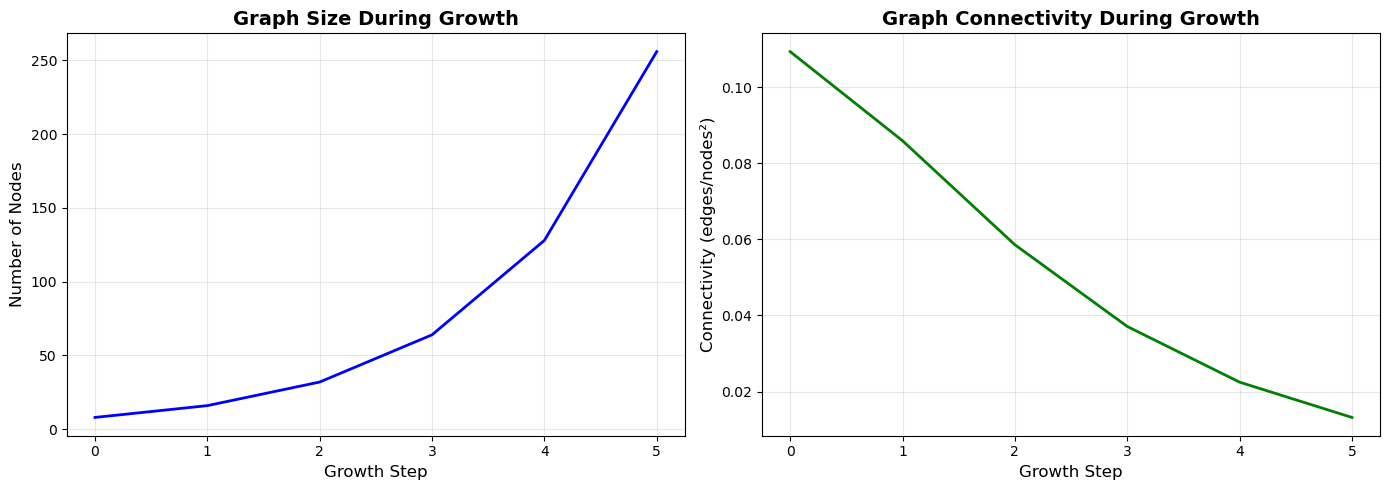


Transient length: 5 steps
Attractor length: 0 steps
No attractor was reached.


In [3]:
# Visualize the growth trajectory
sizes = runner.graph_size()
connectivity = runner.graph_connectivity()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Plot size over time
ax1.plot(sizes, linewidth=2, color='blue')
ax1.set_xlabel('Growth Step', fontsize=12)
ax1.set_ylabel('Number of Nodes', fontsize=12)
ax1.set_title('Graph Size During Growth', fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.3)

# Plot connectivity over time
ax2.plot(connectivity, linewidth=2, color='green')
ax2.set_xlabel('Growth Step', fontsize=12)
ax2.set_ylabel('Connectivity (edges/nodes²)', fontsize=12)
ax2.set_title('Graph Connectivity During Growth', fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Check if we entered an attractor
trans_len, attr_len = runner.attractor_info()
print(f"\nTransient length: {trans_len} steps")
print(f"Attractor length: {attr_len} steps")
if attr_len > 0:
    print("The system entered a repeating pattern!")
else:
    print("No attractor was reached.")

## 2. Visualizing the Grown Graph

Let's visualize some of the graphs generated during the growth process.

Visualizing 4 snapshots of the growth process...

Snapshot 1 (Step 0):
  Nodes: 8, Edges: 7, Connectivity: 0.1094


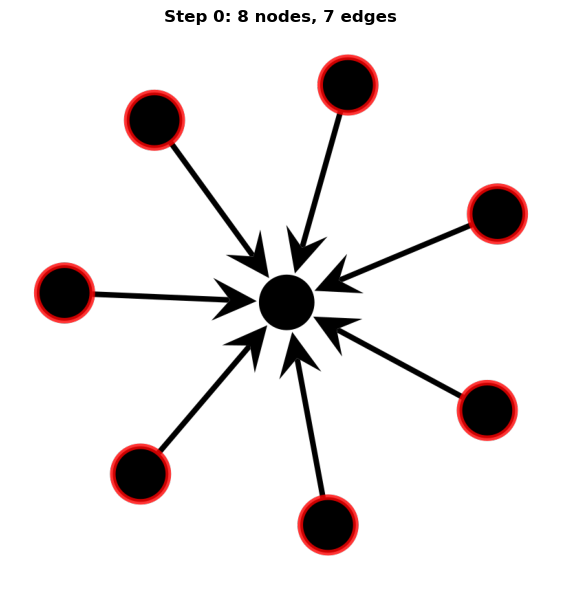


Snapshot 2 (Step 1):
  Nodes: 16, Edges: 22.0, Connectivity: 0.0859


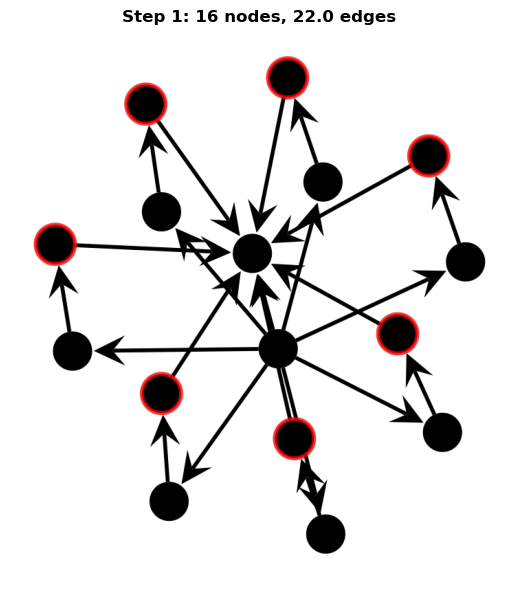


Snapshot 3 (Step 3):
  Nodes: 64, Edges: 152.0, Connectivity: 0.0371


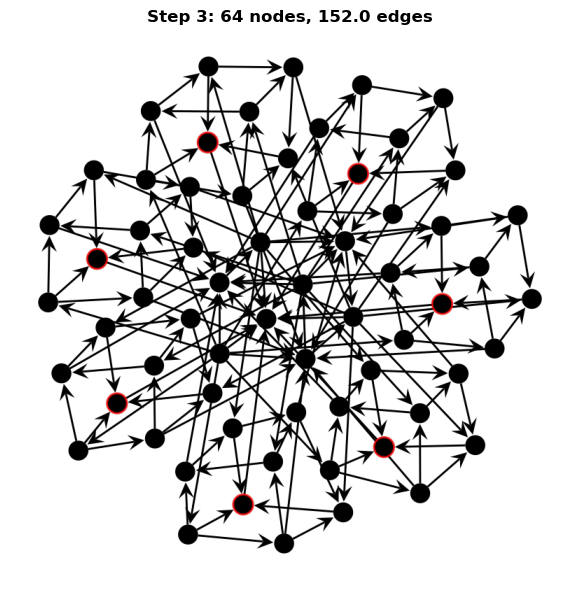


Snapshot 4 (Step 5):
  Nodes: 256, Edges: 864.0, Connectivity: 0.0132


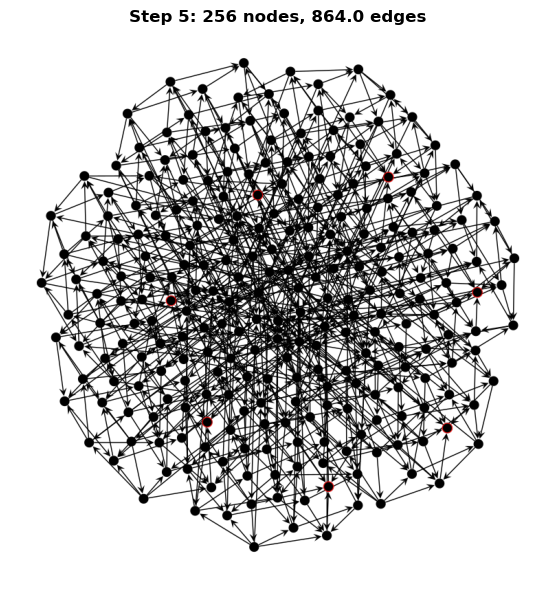

In [4]:
# Select a few snapshots to visualize
n_snapshots = min(4, len(runner.graphs))
snapshot_indices = np.linspace(0, len(runner.graphs)-1, n_snapshots, dtype=int)

print(f"Visualizing {n_snapshots} snapshots of the growth process...\n")

for idx, ax_idx in enumerate(snapshot_indices):
    res = runner.graphs[ax_idx]
    
    print(f"Snapshot {idx+1} (Step {ax_idx}):")
    print(f"  Nodes: {res.size()}, Edges: {res.num_edges()}, Connectivity: {res.connectivity():.4f}")
    
    # Visualize the graph using graph-tool
    if res.size() > 0:
        try:
            # Save to file then display
            filename = f"snapshot_{ax_idx}.png"
            res.draw_gt(output=filename, output_size=(400, 400))
            
            # Display the saved image
            img = plt.imread(filename)
            fig, ax = plt.subplots(figsize=(6, 6))
            ax.imshow(img)
            ax.axis('off')
            ax.set_title(f"Step {ax_idx}: {res.size()} nodes, {res.num_edges()} edges", 
                        fontsize=12, fontweight='bold')
            plt.tight_layout()
            plt.show()
            
            # Clean up temporary file
            import os
            if os.path.exists(filename):
                os.remove(filename)
        except Exception as e:
            print(f"  Error rendering: {str(e)}")
    else:
        print(f"  Graph is empty - nothing to visualize")
    print()

## 3. Training a Reservoir on NARMA Task

Now let's see how a grown reservoir can be used for time-series prediction using the NARMA (Nonlinear AutoRegressive Moving Average) task.

In [5]:
# Set random seed for reproducibility
np.random.seed(2026)

In [6]:
# Use the final reservoir from section 1 for the NARMA task
# Convert it to bipolar weights for better reservoir computing performance
reservoir_for_task = final_reservoir.bipolar()

print(f"Using reservoir from section 1 for NARMA task:")
print(f"  Size: {reservoir_for_task.size()} nodes")
print(f"  Edges: {reservoir_for_task.num_edges()}")
print(f"  Connectivity: {reservoir_for_task.connectivity():.4f}")
print(f"  Largest component: {reservoir_for_task.get_largest_component_frac():.2%}")

Using reservoir from section 1 for NARMA task:
  Size: 128 nodes
  Edges: 368.0
  Connectivity: 0.0225
  Largest component: 100.00%


NARMA task data generated:
  Input shape: (1, 2000)
  Target shape: (1, 2000)

Training complete!
NMSE (lower is better): 0.5904

Training complete!
NMSE (lower is better): 0.5904


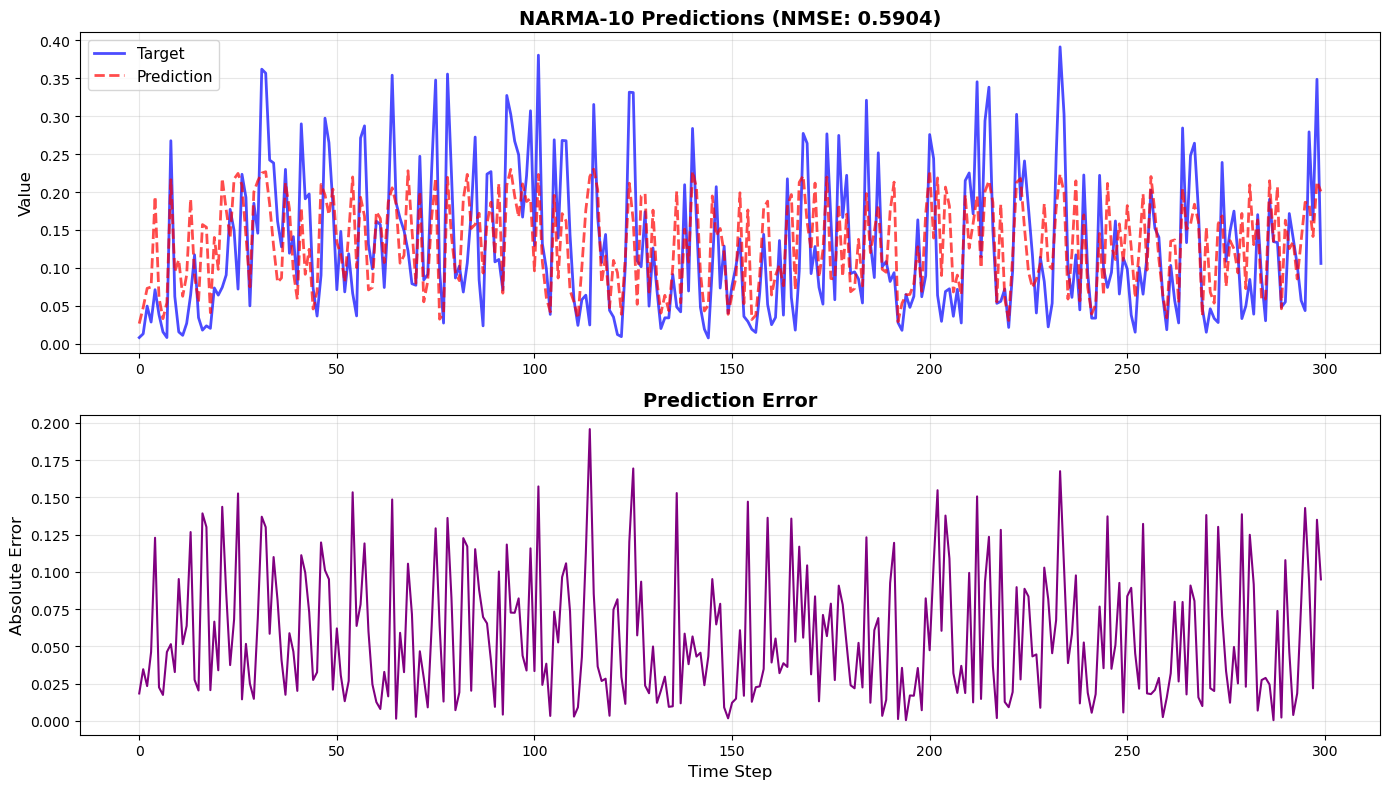

In [8]:
# Generate NARMA-10 task data
input_seq, target_seq = narmax(order=10, num_timesteps=2000)

print(f"NARMA task data generated:")
print(f"  Input shape: {input_seq.shape}")
print(f"  Target shape: {target_seq.shape}")

# Train the reservoir on the NARMA task
reservoir_for_task.reset()
predictions = reservoir_for_task.train(input_seq, target=target_seq)

# Calculate NMSE (Normalized Mean Squared Error)
washout = reservoir_for_task.washout
nmse = np.mean((target_seq[:, washout:] - predictions) ** 2) / np.var(target_seq[:, washout:])

print(f"\nTraining complete!")
print(f"NMSE (lower is better): {nmse:.4f}")

# Visualize predictions vs targets
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 8))

time_window = 300
start_idx = washout
end_idx = start_idx + time_window

# Plot predictions vs target
ax1.plot(target_seq[0, start_idx:end_idx], linewidth=2, label='Target', color='blue', alpha=0.7)
ax1.plot(predictions[0, :time_window], linewidth=2, label='Prediction', color='red', alpha=0.7, linestyle='--')
ax1.set_ylabel('Value', fontsize=12)
ax1.set_title(f'NARMA-10 Predictions (NMSE: {nmse:.4f})', fontsize=14, fontweight='bold')
ax1.legend(fontsize=11)
ax1.grid(True, alpha=0.3)

# Plot error over time
error = np.abs(target_seq[0, start_idx:end_idx] - predictions[0, :time_window])
ax2.plot(error, linewidth=1.5, color='purple')
ax2.set_xlabel('Time Step', fontsize=12)
ax2.set_ylabel('Absolute Error', fontsize=12)
ax2.set_title('Prediction Error', fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 4. Evolutionary Training of DGCA

The key innovation is using evolution to optimize the DGCA's MLPs to grow reservoirs that perform well on tasks. Let's run a short evolutionary training session.

In [36]:
np.random.seed(2026)

In [37]:
# Setup evolutionary parameters (fast configuration for quick demo)
args = SimpleNamespace(
    pop_size=4,              # Small population for faster evolution
    mutate_rate=0.05,        # Higher mutation for faster exploration
    cross_rate=0.5,          # Crossover rate
    cross_style='cols',      # Crossover style
    n_trials=20,             # Fewer trials for quick demo (normally 1000+)
    input_nodes=7,           # No fixed I/O nodes 
    output_nodes=0,
    noise=0.0,               # No noise
    order=10,                # NARMA-10
    task='narma',            # Use NARMA task
    max_size=50,             # Smaller max size for faster growth
    metric=None,
    n_states=3,              # 3 possible node states
    output_dir='demo_results',
    heavy_log=False,
    n_reps_if_noisy=1        # Only 1 rep since noise=0
)

# Define fitness constraints
conditions = {
    "max_size": args.max_size,
    "min_size": args.input_nodes + args.output_nodes + (10 if not args.order else args.order),
}

# Create fitness function
fitness_fn = TaskFitness(
    series=narmax,
    conditions=conditions,
    verbose=False,
    order=args.order,
    fixed_series=True,
)

print("Fitness function created!")
print(f"Task: NARMA-{args.order}")
print(f"Reservoir constraints: min_size={conditions['min_size']}, max_size={conditions['max_size']}")

Fitness function created!
Task: NARMA-10
Reservoir constraints: min_size=17, max_size=50


In [38]:
# Create the evolutionary setup
seed_reservoir = get_seed(args.input_nodes, args.output_nodes, args.n_states)
evolvable_model = EvolvableDGCA(n_states=args.n_states, hidden_size=32, noise=args.noise)  # Smaller hidden size
runner_evo = Runner(max_steps=10, max_size=50)  # Fewer steps and smaller max size for faster growth

mga = ChromosomalMGA(
    popsize=args.pop_size,
    seed_graph=seed_reservoir,
    model=evolvable_model,
    runner=runner_evo,
    fitness_fn=fitness_fn,
    mutate_rate=args.mutate_rate,
    cross_rate=args.cross_rate,
    cross_style=args.cross_style,
    run_id=1,
    n_trials=args.n_trials,
    output_dir=args.output_dir,
    heavy_log=args.heavy_log,
    n_reps_if_noisy=args.n_reps_if_noisy
)

print("\nEvolutionary algorithm initialized!")
print(f"Population size: {args.pop_size}")
print(f"Number of contests: {args.n_trials}")
print(f"Mutation rate: {args.mutate_rate}")
print(f"Crossover rate: {args.cross_rate}")

[run 1] Best-of-run results will be stored in: demo_results/best_run_1.json

Evolutionary algorithm initialized!
Population size: 4
Number of contests: 20
Mutation rate: 0.05
Crossover rate: 0.5


In [39]:
# Run evolution with progress bar
print("\nStarting evolution...\n")
mga.run(progress=True)

print("\n\nEvolution complete!")
print(f"Best fitness achieved: {mga.best['avg_fitness']:.6f}")
print(f"Results saved to: {mga.results_file}")


Starting evolution...



  5%|▌         | 1/20 [00:05<01:46,  5.58s/it, fit=0.603, best=0.603]

[run 1] epoch=0 avg_fit=0.6032444687834442 best_avg=0.6032444687834442
[run 1] epoch=1 avg_fit=0.6008130295272879 best_avg=0.6008130295272879
[run 1] epoch=1 avg_fit=0.6008130295272879 best_avg=0.6008130295272879


 10%|█         | 2/20 [00:10<01:34,  5.27s/it, fit=0.601, best=0.601]

[run 1] epoch=2 avg_fit=0.6613450590861636 best_avg=0.6008130295272879


 20%|██        | 4/20 [00:20<01:20,  5.01s/it, fit=0.601, best=0.601]

[run 1] epoch=3 avg_fit=0.6008196676164251 best_avg=0.6008130295272879
[run 1] epoch=4 avg_fit=0.9996254305413824 best_avg=0.6008130295272879
[run 1] epoch=4 avg_fit=0.9996254305413824 best_avg=0.6008130295272879


 25%|██▌       | 5/20 [00:29<01:39,  6.64s/it, fit=1, best=0.601]    

[run 1] epoch=4 avg_fit=0.9998701496773437 best_avg=0.6008130295272879


 30%|███       | 6/20 [00:35<01:26,  6.18s/it, fit=1, best=0.601]

[run 1] epoch=5 avg_fit=0.9999945010911618 best_avg=0.6008130295272879
[run 1] epoch=6 avg_fit=0.5784806085963506 best_avg=0.5784806085963506
[run 1] epoch=6 avg_fit=0.5784806085963506 best_avg=0.5784806085963506


 40%|████      | 8/20 [00:55<01:34,  7.91s/it, fit=0.99, best=0.578] 

[run 1] epoch=7 avg_fit=0.9899425726038066 best_avg=0.5784806085963506


 45%|████▌     | 9/20 [01:00<01:17,  7.05s/it, fit=0.999, best=0.578]

[run 1] epoch=8 avg_fit=0.9993932720544423 best_avg=0.5784806085963506


 50%|█████     | 10/20 [01:05<01:05,  6.52s/it, fit=0.715, best=0.578]

[run 1] epoch=9 avg_fit=0.7146047184183242 best_avg=0.5784806085963506
[run 1] epoch=10 avg_fit=0.9998743070577693 best_avg=0.5784806085963506
[run 1] epoch=10 avg_fit=0.9998743070577693 best_avg=0.5784806085963506


 55%|█████▌    | 11/20 [01:16<01:09,  7.72s/it, fit=1, best=0.578]    

[run 1] epoch=10 avg_fit=0.9998696017179187 best_avg=0.5784806085963506
[run 1] epoch=11 avg_fit=0.991793107856618 best_avg=0.5784806085963506
[run 1] epoch=11 avg_fit=0.991793107856618 best_avg=0.5784806085963506


 60%|██████    | 12/20 [01:26<01:08,  8.54s/it, fit=0.649, best=0.578]

[run 1] epoch=11 avg_fit=0.6488788866916342 best_avg=0.5784806085963506
[run 1] epoch=12 avg_fit=0.7572738579893602 best_avg=0.5784806085963506
[run 1] epoch=12 avg_fit=0.7572738579893602 best_avg=0.5784806085963506


 65%|██████▌   | 13/20 [01:39<01:09,  9.95s/it, fit=0.539, best=0.539]

[run 1] epoch=12 avg_fit=0.5385634199290213 best_avg=0.5385634199290213
[run 1] epoch=13 avg_fit=0.9964123850143484 best_avg=0.5385634199290213
[run 1] epoch=13 avg_fit=0.9964123850143484 best_avg=0.5385634199290213


 70%|███████   | 14/20 [01:50<01:01, 10.23s/it, fit=0.996, best=0.539]

[run 1] epoch=13 avg_fit=0.9997597952509822 best_avg=0.5385634199290213
[run 1] epoch=14 avg_fit=0.5388002769510081 best_avg=0.5385634199290213
[run 1] epoch=14 avg_fit=0.5388002769510081 best_avg=0.5385634199290213


 75%|███████▌  | 15/20 [02:00<00:51, 10.20s/it, fit=0.539, best=0.539]

[run 1] epoch=14 avg_fit=0.7175922238752105 best_avg=0.5385634199290213
[run 1] epoch=15 avg_fit=0.8861483445260246 best_avg=0.5385634199290213
[run 1] epoch=15 avg_fit=0.8861483445260246 best_avg=0.5385634199290213


 80%|████████  | 16/20 [02:11<00:40, 10.22s/it, fit=0.886, best=0.539]

[run 1] epoch=15 avg_fit=0.9998262281981972 best_avg=0.5385634199290213
[run 1] epoch=16 avg_fit=0.9943317751467985 best_avg=0.5385634199290213
[run 1] epoch=16 avg_fit=0.9943317751467985 best_avg=0.5385634199290213


 85%|████████▌ | 17/20 [02:22<00:31, 10.45s/it, fit=0.565, best=0.539]

[run 1] epoch=16 avg_fit=0.5652904828826382 best_avg=0.5385634199290213
[run 1] epoch=17 avg_fit=0.7862033472747788 best_avg=0.5385634199290213
[run 1] epoch=17 avg_fit=0.7862033472747788 best_avg=0.5385634199290213


 90%|█████████ | 18/20 [02:30<00:19,  9.75s/it, fit=0.613, best=0.539]

[run 1] epoch=17 avg_fit=0.6133266582952814 best_avg=0.5385634199290213
[run 1] epoch=18 avg_fit=0.6629456609102469 best_avg=0.5385634199290213
[run 1] epoch=18 avg_fit=0.6629456609102469 best_avg=0.5385634199290213


 95%|█████████▌| 19/20 [02:38<00:09,  9.42s/it, fit=0.581, best=0.539]

[run 1] epoch=18 avg_fit=0.5811307844536591 best_avg=0.5385634199290213
[run 1] epoch=19 avg_fit=0.6823625518807062 best_avg=0.5385634199290213
[run 1] epoch=19 avg_fit=0.6823625518807062 best_avg=0.5385634199290213


100%|██████████| 20/20 [02:48<00:00,  8.40s/it, fit=0.664, best=0.539]

[run 1] epoch=19 avg_fit=0.6641884182573058 best_avg=0.5385634199290213
[run 1] Saved best: avg_fitness=0.5385634199290213 to demo_results/best_run_1.json


Evolution complete!
Best fitness achieved: 0.538563
Results saved to: demo_results/best_run_1.json


## 5. Analyzing the Best Evolved DGCA

Let's examine the best DGCA model found by evolution and the reservoirs it grows.

In [40]:
# Get the best evolved model
best_model = mga.best['model']
best_fitnesses = mga.best['fitnesses']
best_reservoirs = mga.best['reservoirs']

print(f"Best model fitness: {mga.best['avg_fitness']:.6f}")
print(f"Number of reservoir instances: {len(best_reservoirs)}")

if len(best_reservoirs) > 0:
    # Examine first reservoir instance
    best_res = best_reservoirs[0]
    print(f"\nBest reservoir stats:")
    print(f"  Size: {best_res.size()} nodes")
    print(f"  Edges: {best_res.num_edges()}")
    print(f"  Connectivity: {best_res.connectivity():.4f}")
    print(f"  Largest component fraction: {best_res.get_largest_component_frac():.4f}")

Best model fitness: 0.538563
Number of reservoir instances: 1

Best reservoir stats:
  Size: 33 nodes
  Edges: 135.0
  Connectivity: 0.1240
  Largest component fraction: 1.0000


Visualizing 1 reservoir(s) from best model...

Sample 1:
  Nodes: 33, Edges: 135.0
  Connectivity: 0.1240, NMSE: 0.5386


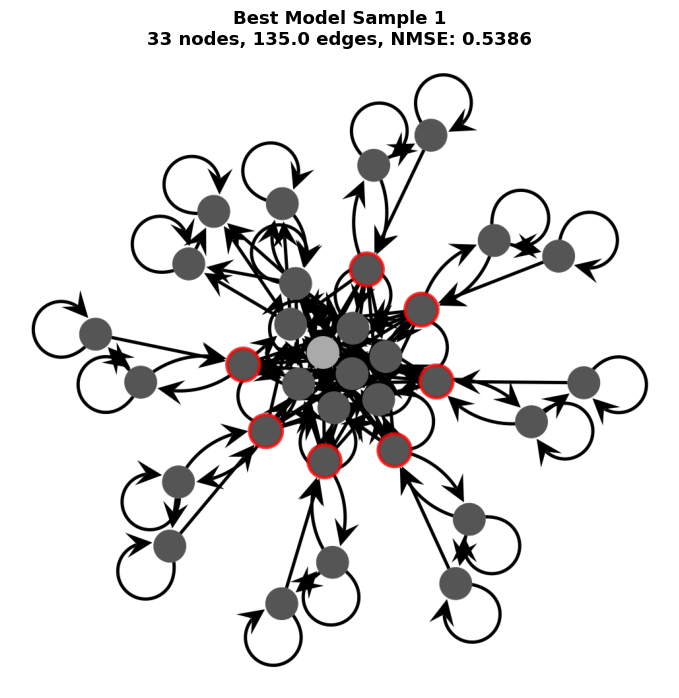

In [41]:
# Visualize multiple reservoirs grown by the best model
n_samples = min(3, len(best_reservoirs))

print(f"Visualizing {n_samples} reservoir(s) from best model...\n")

for i in range(n_samples):
    res = best_reservoirs[i]
    fit = best_fitnesses[i] if i < len(best_fitnesses) else np.nan
    
    print(f"Sample {i+1}:")
    print(f"  Nodes: {res.size()}, Edges: {res.num_edges()}")
    print(f"  Connectivity: {res.connectivity():.4f}, NMSE: {fit:.4f}")
    
    if res.size() > 0:
        try:
            # Save to file then display
            filename = f"best_reservoir_{i}.png"
            res.draw_gt(output=filename, output_size=(500, 500))
            
            # Display the saved image
            img = plt.imread(filename)
            fig, ax = plt.subplots(figsize=(7, 7))
            ax.imshow(img)
            ax.axis('off')
            ax.set_title(f"Best Model Sample {i+1}\n{res.size()} nodes, {res.num_edges()} edges, NMSE: {fit:.4f}", 
                        fontsize=13, fontweight='bold')
            plt.tight_layout()
            plt.show()
            
            # Clean up temporary file
            import os
            if os.path.exists(filename):
                os.remove(filename)
        except Exception as e:
            print(f"  Error rendering: {str(e)}")
    else:
        print(f"  Empty graph - nothing to visualize")
    print()

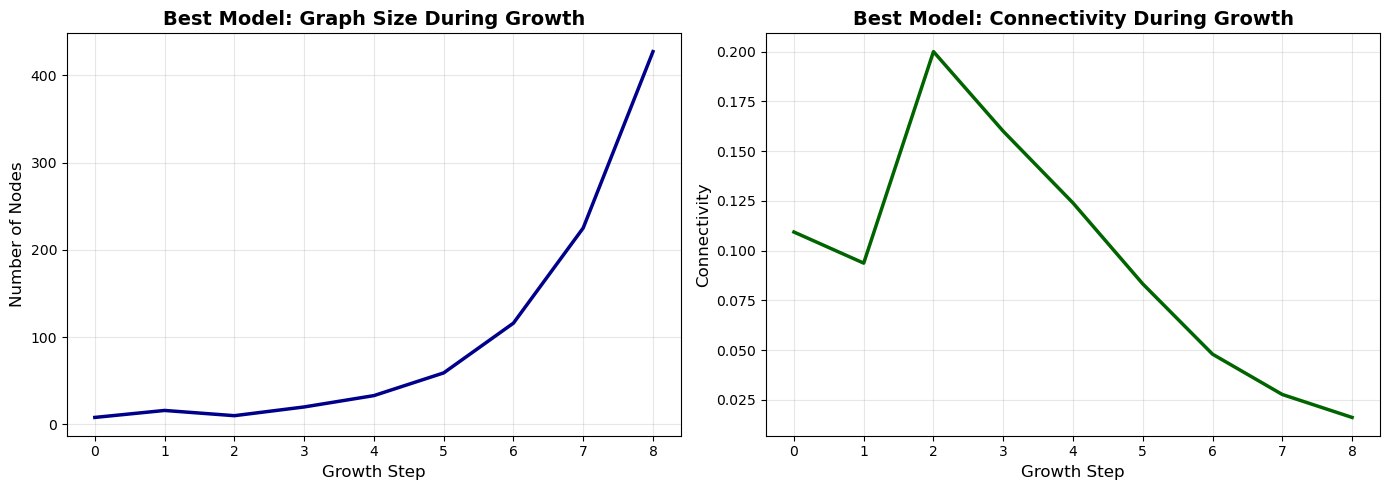


Growth trajectory of best model:
  Final size: 225 nodes
  Final connectivity: 0.0278
  Status: max_size
  Transient: 8, Attractor: 0


In [42]:
# Grow a new reservoir using the best model and watch its growth
if best_model is not None:
    runner_best = Runner(max_steps=100, max_size=300)
    final_best = runner_best.run(best_model, seed_reservoir)
    
    sizes_best = runner_best.graph_size()
    conn_best = runner_best.graph_connectivity()
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
    
    ax1.plot(sizes_best, linewidth=2.5, color='darkblue')
    ax1.set_xlabel('Growth Step', fontsize=12)
    ax1.set_ylabel('Number of Nodes', fontsize=12)
    ax1.set_title('Best Model: Graph Size During Growth', fontsize=14, fontweight='bold')
    ax1.grid(True, alpha=0.3)
    
    ax2.plot(conn_best, linewidth=2.5, color='darkgreen')
    ax2.set_xlabel('Growth Step', fontsize=12)
    ax2.set_ylabel('Connectivity', fontsize=12)
    ax2.set_title('Best Model: Connectivity During Growth', fontsize=14, fontweight='bold')
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print(f"\nGrowth trajectory of best model:")
    print(f"  Final size: {final_best.size()} nodes")
    print(f"  Final connectivity: {final_best.connectivity():.4f}")
    print(f"  Status: {runner_best.status}")
    trans, attr = runner_best.attractor_info()
    print(f"  Transient: {trans}, Attractor: {attr}")